In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import itertools
from collections import defaultdict

from utils.plot_config import *
mpl.rc('lines', linewidth=plot_line_width)

In [2]:
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

def format_plot(ax, make_legend):
    if make_legend:
        ncol = 5
        handles, labels = ax.get_legend_handles_labels()
        handles, labels = flip(handles, ncol), flip(labels, ncol)
        ax.legend(handles, labels, loc="upper center", prop={'size': fontsize*1.3}, bbox_to_anchor=(0.5, -0.125), ncol=5)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(plot_axis_line_width)
    ax.tick_params(width=plot_axis_line_width*2)
    ax.tick_params(axis='both', which='major', labelsize=fontsize*1.2)
    ax.tick_params(axis='x', which='major', labelsize=fontsize*1.0, rotation=0)

In [3]:
def load_dataset_stats(dataset_names, dataset_methods, metric_n, metric):
    dataset_stats = defaultdict(dict)
    file_path = "./data/results/sampling_results"
    metric_file_names = os.listdir(file_path)
    for dataset_name, dataset_value in dataset_names.items():
        for method in dataset_methods.keys():
            curr_fn = f"{dataset_value}_{method}_{metric}"
            metric_file_name = next((fn for fn in metric_file_names if curr_fn in fn), None)
            if metric_file_name is None:
                raise ValueError(f"No matching {metric} or {method} file for dataset: {dataset_name} (file name: {metric_file_name}.tsv)")
            data = pd.read_csv(os.path.join(file_path, metric_file_name), sep='\t')
            dataset_stats[dataset_name][method] = data.values.flatten()[np.array(metric_n)-1]
    return dataset_stats

In [4]:
def create_barplot(ax, labels, dataset_stats, colormap, x_label, make_legend):
    x = np.arange(len(labels))
    width = 0.1
    multiplier = 0
    for i, (attribute, measurement) in enumerate(dataset_stats.items()):
        measurement = np.array(measurement)
        offset = width * multiplier
        ax.bar(x + offset, measurement, width, label=attribute, color=colormap[i])
        multiplier += 1
    ax.set_xticks(x + 4*width, labels)
    ax.set_xlabel(x_label, fontsize=fontsize*1.4, labelpad=10)
    format_plot(ax, make_legend=make_legend)

In [5]:
dataset_names = {"Coveo":"coveo_optuna_recall_bprmax_constrained_fulltrain", "Retailrocket": "retailrocket_optuna_recall_bprmax_constrained_fulltrain"} 
dataset_methods = {"full": "All items", "similar": "Most similar", "closest": "Closest", "popstatic": "Most popular", "popular": "Popularity sampling", "uniform": "Uniform sampling", "invpopular": "Inverse popularity sampling", "farthest": "Farthest", "dissimilar": "Least similar"}
metric = "recall"
metric_n = [1,5,10,20]
recalls_labels = np.array([f"Recall@{n}" for n in metric_n])

In [6]:
cmap = np.array(mpl.colormaps['tab20c'](np.arange(8)))
oranges = cmap[4:8][::-1]
blues = np.repeat(np.array([[24, 82, 124]]), 4, axis=0)
blue_alphas = np.array([1.0,0.75,0.5,0.25]).reshape(-1,1)
blues = np.hstack([blues/255, blue_alphas])
cmap = np.vstack([blues, oranges])
cmap = np.vstack([np.array([0,0,0,1]), cmap])

In [7]:
dataset_stats = load_dataset_stats(dataset_names, dataset_methods, metric=metric, metric_n=metric_n)

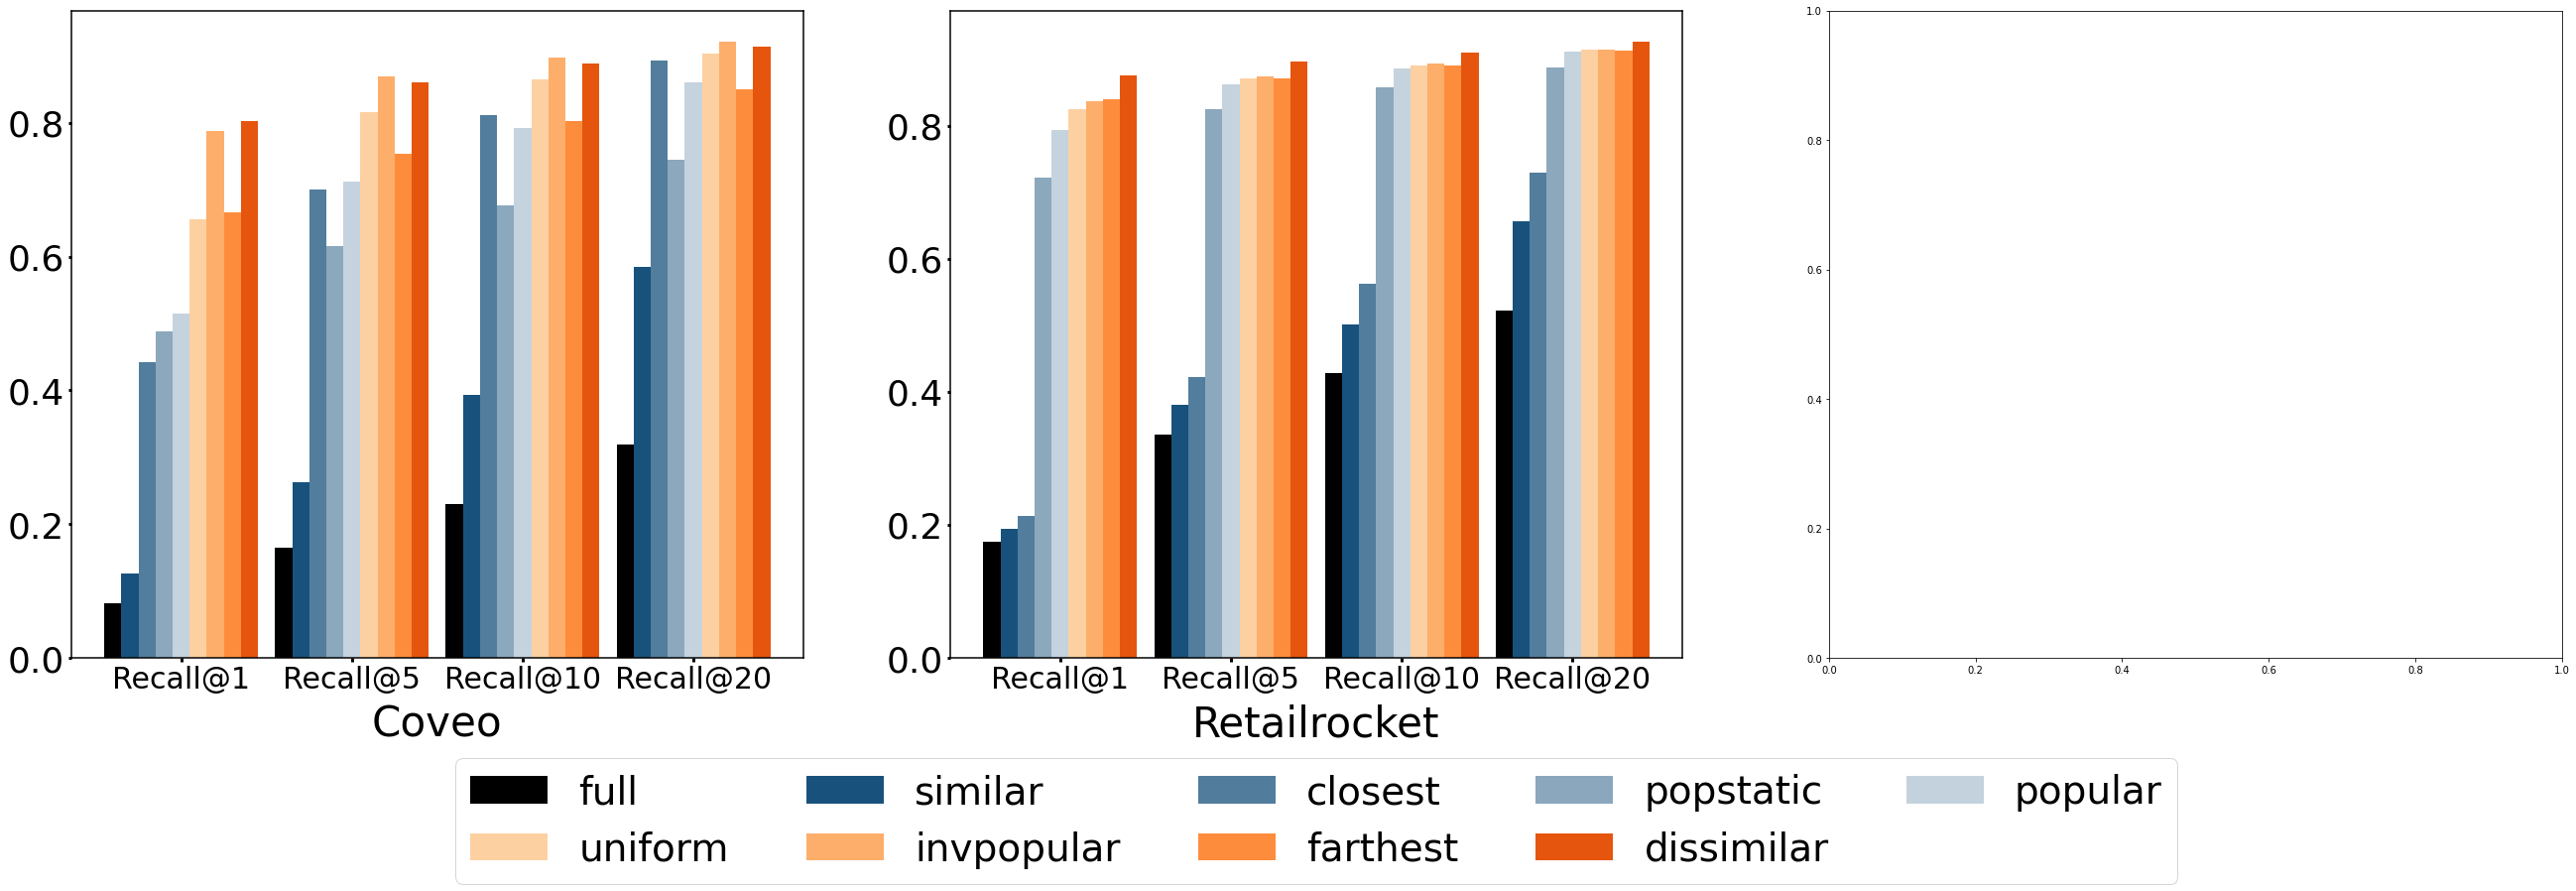

In [8]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(45,12))
for i, ds_name in enumerate(dataset_names.keys()):
    ax = axs[i] 
    create_barplot(ax, labels=recalls_labels, dataset_stats=dataset_stats[ds_name], colormap=cmap, x_label=ds_name, make_legend=True if i == 1 else False)